In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ngsolve import *
from ngsolve.webgui import Draw

In [5]:
import importlib
import sys
from pathlib import Path
import os 
sys.path.append(str(Path(os.getcwd()).parent / "src"))

import active_gel_fem
importlib.reload(active_gel_fem)

import utils 
importlib.reload(utils)

from ngsolve.webgui import Draw

In [117]:
tanh = lambda arg: (exp(arg) - exp(-arg))/(exp(arg)+exp(-arg)) 
left_edge = 0.5 - 0.06
right_edge = 0.5 + 0.06
left_transition = 0.5 * (tanh((x - left_edge)/0.01))
right_transition = 0.5 * (tanh((right_edge - x)/0.01))

bottom_transition = 0.5 * (tanh((y - 0.1)/0.1))
top_transition = 0.5 * (tanh((0.9 - y)/0.1))
source =1*(left_transition + right_transition) *(top_transition + bottom_transition)

def add_cbar(ax, im, vmin, vmax, label):
    cbar = plt.colorbar(im, ax=ax, location='bottom', pad=0.1)
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([f'{vmin:.2g}', f'{vmax:.2g}'])
    cbar.set_label(label, fontsize=20)
    return cbar

def plot_frame(n_samples, rho, div_v, vx, vy, nx, ny, Qxx, filename, stride=3):
    X = np.linspace(0, 1, n_samples)
    Y = np.linspace(0, 1, n_samples)
    X, Y = np.meshgrid(X, Y)

    # Plot the contour for rho_vals
    fig, axes = plt.subplots(1, 4, figsize=(17, 5))

    # Density plot
    im0 = axes[0].imshow(rho, aspect='auto', interpolation='none',
                          origin='upper', cmap='inferno', extent=(0, 1, 1, 0))
    add_cbar(axes[0], im0, np.min(rho), np.max(rho), r'actin density')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Velocity plot
    mag = np.sqrt(vx**2+vy**2)
    im2 = axes[1].pcolor(X, Y, mag, cmap='Reds')
    add_cbar(axes[1], im2, np.min(mag), np.max(mag), r'$v$')
    axes[1].quiver(X[2::stride, 2::stride], Y[2::stride, 2::stride],
                   (vx/mag)[2::stride, 2::stride], (vy /
                                                    mag)[2::stride, 2::stride],
                   scale=15,
                   width=0.011, pivot='mid', headwidth=3, headlength=3, headaxislength=3,
                   color='black'
                   )
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Compression rate plot
    max_div_v = np.max(np.abs(div_v))
    im1 = axes[2].pcolor(X, Y, div_v, cmap='RdBu_r', vmin=-max_div_v, vmax=max_div_v)
    add_cbar(axes[2], im1, -max_div_v, max_div_v, r'-$\nabla \cdot v$')
    axes[2].set_xticks([])
    axes[2].set_yticks([])

    # Nematic order plot
    mag = np.sqrt(nx**2 + ny**2)
    vmax = np.max(np.abs(Qxx))
    vmin = - vmax
    im3 = axes[3].pcolor(X, Y, -Qxx, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    add_cbar(axes[3], im3, vmin, vmax, r'$Q_{yy}$')
    axes[3].quiver(X[2::stride, 2::stride], Y[2::stride, 2::stride],
                   (nx/mag)[2::stride, 2::stride], (ny /
                                                    mag)[2::stride, 2::stride],
                   color='black', scale=20, width=0.010, pivot='mid', headwidth=0, headlength=0, headaxislength=0
                   )
    axes[3].set_xticks([])
    axes[3].set_yticks([])

    plt.tight_layout()
    plt.savefig(filename, dpi=400)
    plt.show()
    
    


In [112]:
T = 20
tau = 0.1
chi0 = 0.2
chi1 = 10
beta_prod = 1
beta2 = 1
beta1 = beta_prod/beta2
eta = 1 
gamma = eta 
D = 1e-4 

# parameters for isotropic active gel 
# chi0 = 2.5
# chi1 = 0.
# D = 5e-4 
# gamma = eta*100 



tanh = lambda arg: (exp(arg) - exp(-arg))/(exp(arg)+exp(-arg)) 
left_edge = 0.5 - 0.05
right_edge = 0.5 + 0.05
left_transition = 0.5 * (tanh((x - left_edge)/0.005))
right_transition = 0.5 * (tanh((right_edge - x)/0.005))

half_length = lambda t: 0.
bottom_transition = lambda t: 0.5 * (tanh((y - (0.1-half_length(t)))/0.01))
top_transition = lambda t: 0.5 * (tanh((0.9 + half_length(t)- y)/0.01))
source = lambda t: 1*(left_transition + right_transition) *(top_transition(t) + bottom_transition(t))


sim = active_gel_fem.NematicActiveGel2D(
                    width=1, height=1, maxh=0.03,
                    gamma=gamma, eta_1=eta, eta_2=0,
                    k=1, D=5e-4,
                    kappa =1e-4,
                    beta1 = beta1, beta2 = beta2,   
                    chi0 = chi0,  chi1 = chi1,
                    Qsq = lambda t: -1, #+2*source(t), 
                    rho0 = lambda t: 1+0.1*source(t))

sim.density.Set(1)

# for i in range(len(sim.density.vec.data)): 
#     sim.density.vec.data[i] = np.random.normal(1, 0.05)
#     sim.nematic_xx.vec.data[i] = np.random.normal(0, 0.05)

sim.simulate(
    tend=T,
    tau=tau,
    save_interval=int(1/tau) # save once a second 
)

 14%|█▎        | 27/200 [00:00<00:01, 132.31it/s]

craete bilinearformapplication


100%|██████████| 200/200 [00:01<00:00, 120.74it/s]


In [95]:
sim.visualize(animate=False)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [113]:
n_samples = 60
data = sim.export_to_npy(f'sim_data/active_gel_chi0_{chi0}_chi1_{chi1}', n_samples=n_samples)

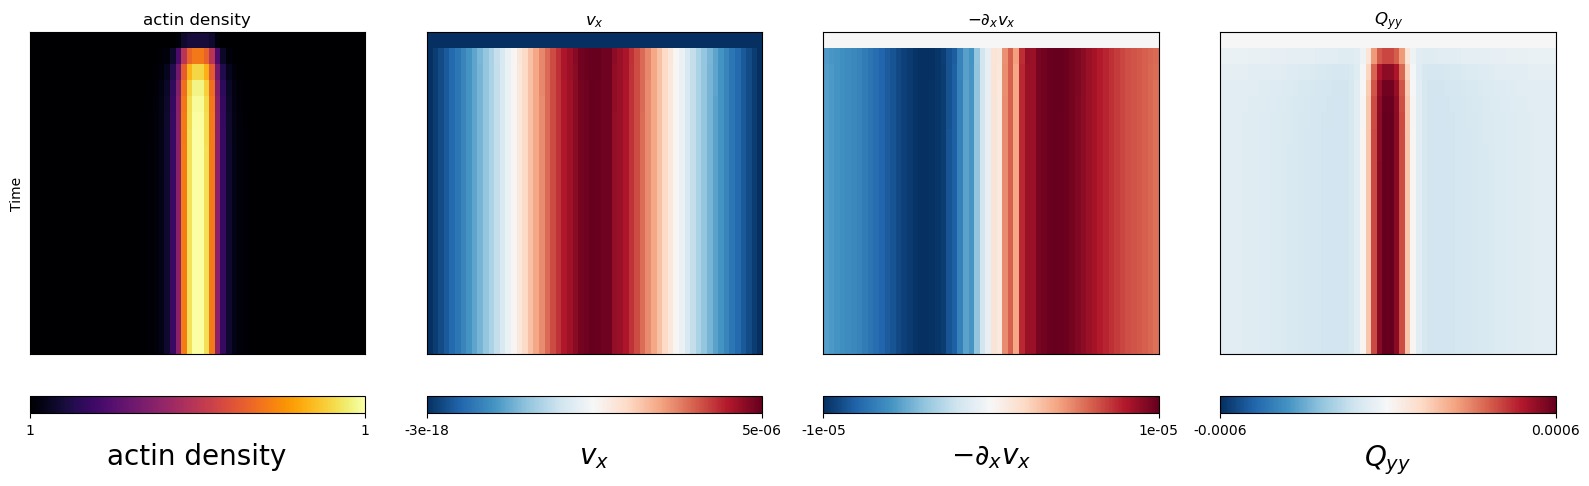

In [114]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=True, sharey=True)
start_index = 0 
end_index = int(20/0.5)
n_samples = 60

data_kymo = data[start_index:end_index] 
vx = data_kymo[:, 24, :, 2]
dxvx = np.gradient(vx, axis=1)/(1/n_samples)
density = data_kymo[:, 24, :, 1] + data_kymo[:, 24, :, 0]

fields = [
    (density, r'actin density', 'inferno', np.min(density), np.max(density)),
    (vx, r'$v_x$',  'RdBu_r', np.min(vx), np.max(vx)),
    (- dxvx, r'$ - \partial_x v_x$', 'RdBu_r', -np.max(dxvx), np.max(dxvx)),
    (- data[:, 24, :, -2], r'$Q_{yy}$',
     'RdBu_r', np.min(data[:, 24, :, -2]), - np.min(data[:, 24, :, -2]))
]

for ax, (field, title, cmap, vmin, vmax) in zip(axes, fields):
    im = ax.imshow(field, aspect='auto', interpolation='none',
                   origin='upper', cmap=cmap, extent=(0, 1, T/2, 0), vmin=vmin, vmax=vmax)
    add_cbar(ax, im, vmin, vmax, title)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_ylabel('Time')

plt.tight_layout()
plt.show()

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_89818/1317736504.py:38: RuntimeWarning: invalid value encountered in divide
  (vx/mag)[2::stride, 2::stride], (vy /


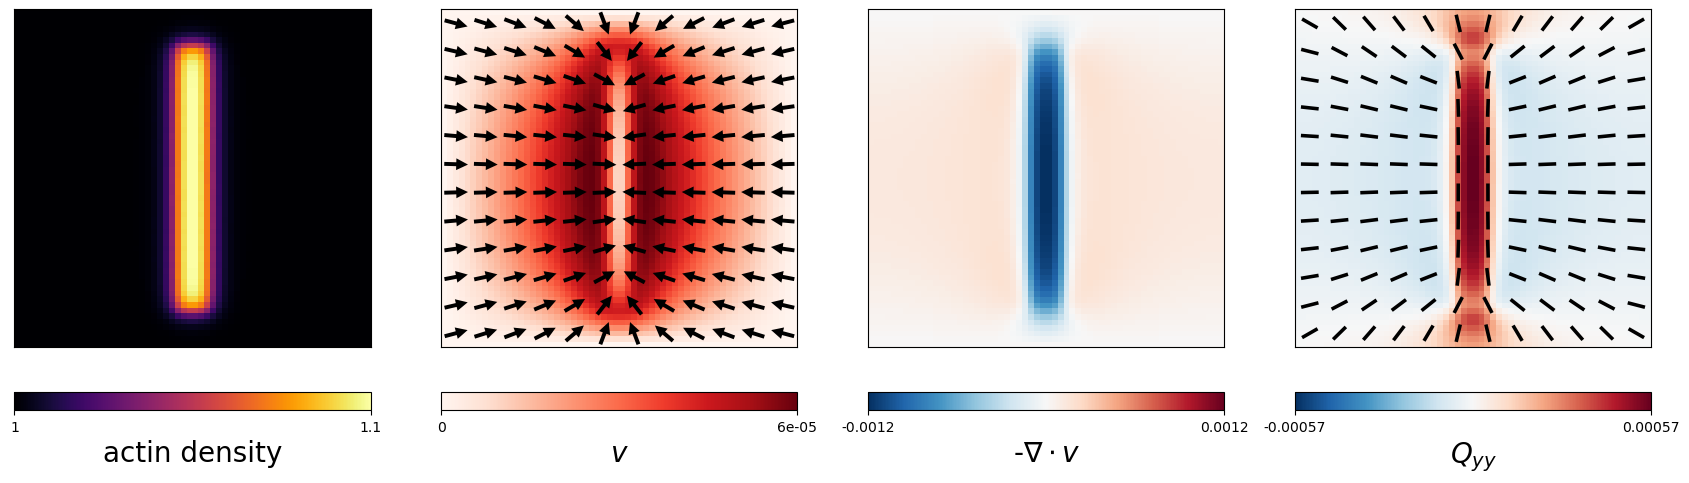

In [118]:
t = -1
rho, vx, vy, Q, q = np.rollaxis(data[t], -1)
nx, ny = utils.nematic_to_vector(Q, q)
div_v = np.gradient(vx, axis=1)/(1/n_samples)

filename = '../figures/nem_no_phase_separation_2d.png'
plot_frame(n_samples, rho, div_v, vx, vy, nx, ny, Q, filename, stride=5)


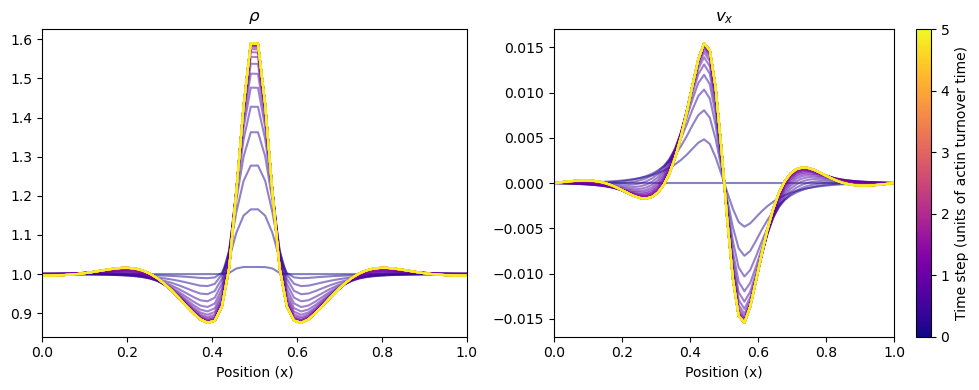

In [109]:
rho = data[:50, 24,  :, 0] 
vx = data[:50, 24, :, 1]

x_grid  = np.linspace(0, 1, n_samples)


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

colors = plt.cm.plasma(np.linspace(0, 1, len(rho)))
for i in range(len(rho)): 
    axes[0].plot(x_grid, rho[i], '-', alpha=0.5, color=colors[i])
    axes[1].plot(x_grid, vx[i], '-', alpha=0.5, color=colors[i])
axes[0].set_title(r'$\rho$')
axes[1].set_title(r'$v_x$')

# Add colorbar for time
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=len(rho)*tau))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1], shrink=1)
cbar.set_label('Time step (units of actin turnover time)')

axes[0].set_xlabel('Position (x)') 
axes[1].set_xlabel('Position (x)') 
axes[0].set_xlim(0, 1)

plt.tight_layout()
plt.savefig('../figures/iso_kymo_with_band.png')
plt.show()